In [16]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import json 
from toolkit import *
from Visuals import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
import warnings
import shap
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names.*")

/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data=load_data(train=True)
test_data=load_data(train=False)

In [3]:
train_data=train_data.drop(columns=['transaction_id','timestamp','user_id','merchant_id', 
                        'signup_date','sex','geometry','continent_user', 'continent_merchant',
                         'continent_transaction','currency'],axis=1)
test_data=test_data.drop(columns=['transaction_id','timestamp','user_id','merchant_id', 
                        'signup_date','sex','geometry','continent_user', 'continent_merchant',
                         'continent_transaction','currency'],axis=1)

In [4]:
with open('savedModels/SelectedColumns/intersection.json', 'r') as f:
    intersection = list(json.load(f))


In [5]:
y_train=np.ravel(train_data[['is_fraud']])
df_train=train_data.drop(columns=['is_fraud'],axis=1)

y_test=np.ravel(test_data[['is_fraud']])
df_test=test_data.drop(columns=['is_fraud'],axis=1)

In [38]:
colTrans=make_preprocessor(df_train) 
colTrans.fit(df_train)

processed_names = colTrans.get_feature_names_out(df_train.columns)  # all one-hot / scaled names
selected_names = processed_names[intersection_indexes]              # human-readable names
selected_idx   = np.asarray(intersection_indexes)                   # to slice the matrix

slice_cols = FunctionTransformer(
    func=lambda X: X[:, selected_idx],                              # slice by position
    feature_names_out=lambda self, input_features: selected_names   # hand back real names
)

In [39]:
Estimators=[
    ('xgb',XGBClassifier(gamma=0.2,colsample_bytree=0.8,learning_rate=0.01,n_estimators=300, 
                          reg_lambda=0,max_depth=3,scale_pos_weight=10, random_state=42)), 
    ('lgbm', LGBMClassifier(is_unbalance=True, n_estimators=700,reg_lambda=0,max_depth=3,learning_rate=0.1, 
                         colsample_bytree=0.8,min_split_gain=0,random_state=42,verbosity=-1)), 
    ('tree', DecisionTreeClassifier(ccp_alpha=0.01,class_weight='balanced',criterion='gini', max_depth=4, 
                                 random_state=42)),
    ('rf', RandomForestClassifier(random_state=42,class_weight='balanced',max_depth=25, max_features='log2', 
                n_estimators=10,min_samples_split=2))]

In [40]:
SoftEstimator=VotingClassifier(
    estimators=Estimators, 
    voting='soft', 
    n_jobs=3
) 
       


pipe = Pipeline([
    ('prep',    colTrans),           
    ('select',  slice_cols),         
    ('model',   SoftEstimator)
])


In [19]:
## Choosing threshold

In [20]:
X_train_train,X_train_test,y_train_train,y_train_test=train_test_split(df_train,y_train,stratify=y_train,test_size=0.1
                                                                       , random_state=42)

In [21]:
pipe.fit(X_train_train,y_train_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount',
                                                   'session_length_seconds',
                                                   'age',
                                                   'sum_of_monthly_installments',
                                                   'sum_of_monthly_expenses',
                                                   'risk_score', 'trust_score',
                                                   'number_of_alerts_last_6_months',
                                                   'avg_transaction_amount',
                                                   'account_age_months',
                                                   'cosine_similarity_hist_all',
                                                   'euclidian_similarity_hist_all',
                                                   'risk_...
                                                              is_unbalance=True,
                                                              max_depth=3,
                                                              min_split_gain=0,
                                                              n_estimators=700,
                                                              random_state=42,
                                                              reg_lambda=0,
                                                              verbosity=-1)),
                                              ('tree',
                                               DecisionTreeClassifier(ccp_alpha=0.01,
                                                                      class_weight='balanced',
                                                                      max_depth=4,
                                                                      random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=25,
                                                                      max_features='log2',
                                                                      n_estimators=10,
                                                                      random_state=42))],
                                  n_jobs=3, voting='soft'))])

In [22]:
y_predict_proba=pipe.predict_proba(X_train_test)[:,1] 
y_predict=pipe.predict(X_train_test)

PredictionQualityInfo(y_predict,y_train_test)
RecallTresholdPlot(y_predict_proba,y_train_test)

## Final Prediction

In [41]:
treshold=0.5

In [42]:
pipe.fit(df_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount',
                                                   'session_length_seconds',
                                                   'age',
                                                   'sum_of_monthly_installments',
                                                   'sum_of_monthly_expenses',
                                                   'risk_score', 'trust_score',
                                                   'number_of_alerts_last_6_months',
                                                   'avg_transaction_amount',
                                                   'account_age_months',
                                                   'cosine_similarity_hist_all',
                                                   'euclidian_similarity_hist_all',
                                                   'risk_...
                                                              is_unbalance=True,
                                                              max_depth=3,
                                                              min_split_gain=0,
                                                              n_estimators=700,
                                                              random_state=42,
                                                              reg_lambda=0,
                                                              verbosity=-1)),
                                              ('tree',
                                               DecisionTreeClassifier(ccp_alpha=0.01,
                                                                      class_weight='balanced',
                                                                      max_depth=4,
                                                                      random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=25,
                                                                      max_features='log2',
                                                                      n_estimators=10,
                                                                      random_state=42))],
                                  n_jobs=3, voting='soft'))])

In [43]:
y_predict_proba=pipe.predict_proba(df_test)

In [44]:
y_pred=np.where(y_predict_proba[:,1]>=treshold,1,0)

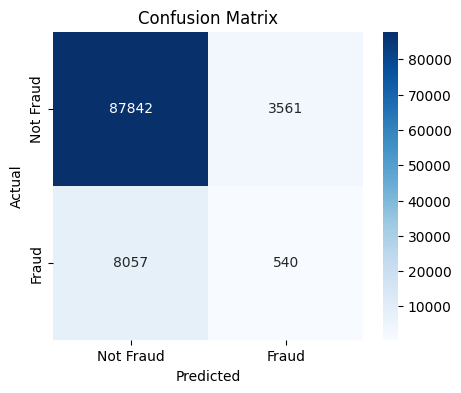

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     91403
           1       0.13      0.06      0.09      8597

    accuracy                           0.88    100000
   macro avg       0.52      0.51      0.51    100000
weighted avg       0.85      0.88      0.86    100000



In [45]:
PredictionQualityInfo(y_pred,y_test)

## Shap value

PermutationExplainer explainer: 201it [00:50,  3.10it/s]                                                                                                                                                           
/var/folders/lv/tkghl1_16tqcn5rtywgj_bgw0000gn/T/ipykernel_11309/3822214275.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], X_transformed[:200],


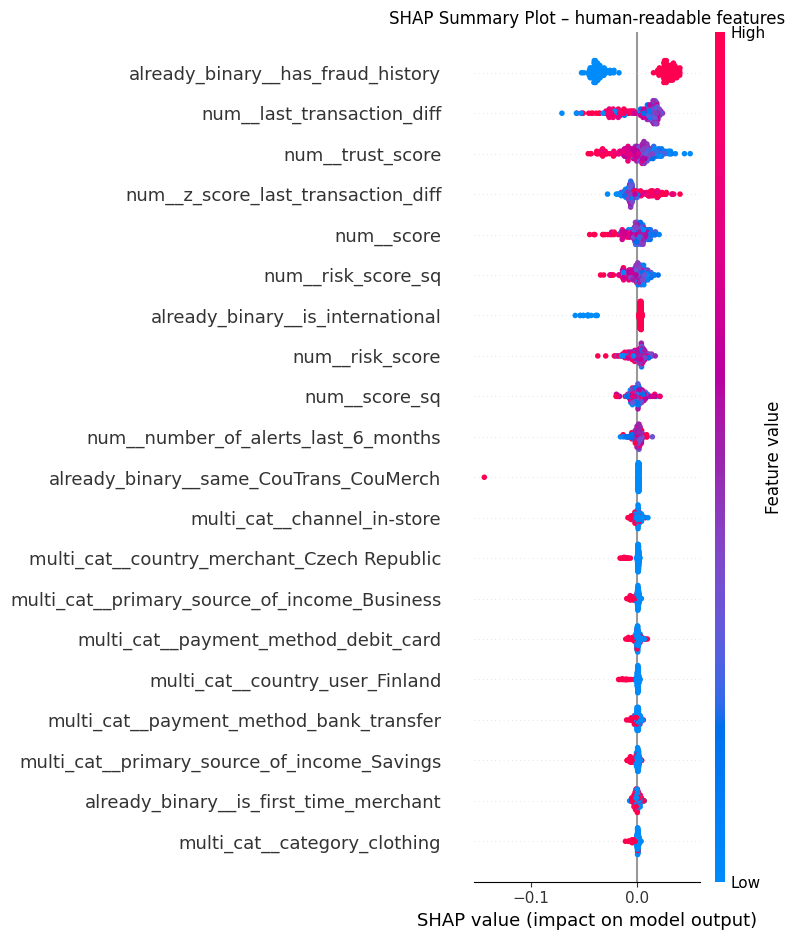

In [46]:
X_transformed = pipe[:-1].transform(df_train)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()
X_transformed = X_transformed.astype(np.float32)


feature_names = pipe.named_steps["select"].get_feature_names_out()

masker = shap.maskers.Independent(X_transformed[:100])            
explainer = shap.Explainer(pipe.named_steps["model"].predict_proba,
                           masker=masker,
                           feature_names=feature_names)

shap_values = explainer(X_transformed[:200])                      


/var/folders/lv/tkghl1_16tqcn5rtywgj_bgw0000gn/T/ipykernel_11309/707808656.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], X_transformed[:200],


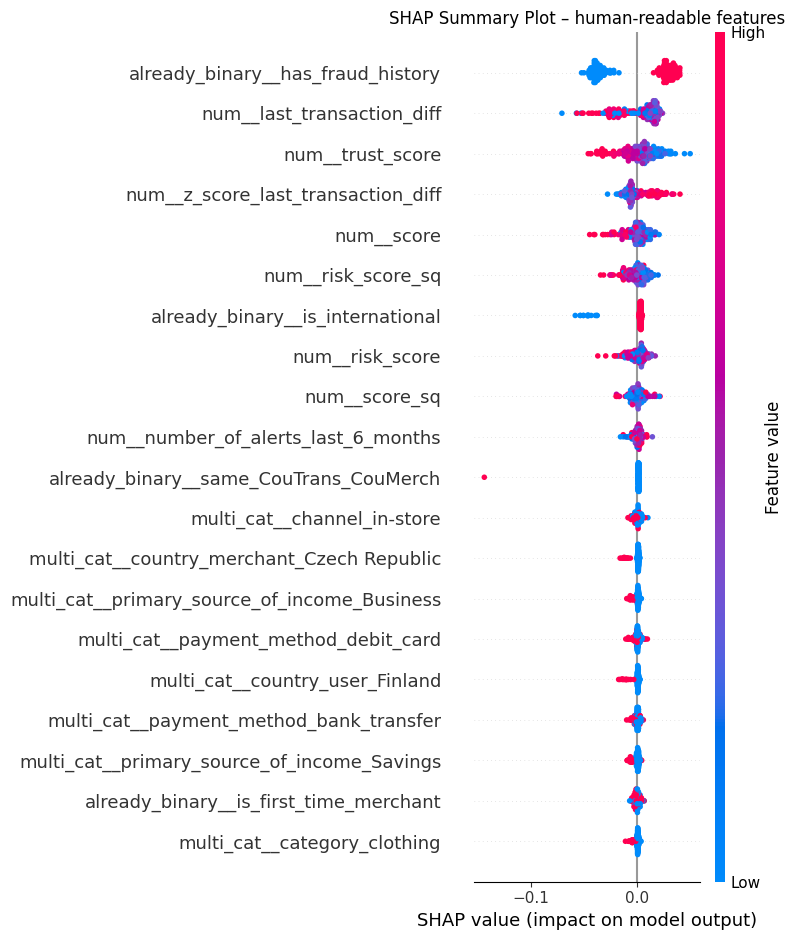

In [47]:
plt.figure(figsize=(18, 12))
shap.summary_plot(shap_values[..., 1], X_transformed[:200],
                  feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot – human-readable features")
plt.tight_layout()
plt.show()